(512, 512)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


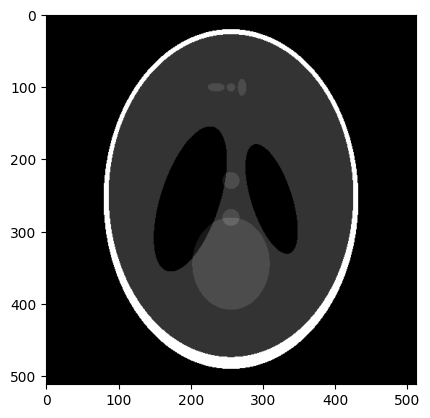

In [2]:
import numpy as np
import phantominator
from phantominator import shepp_logan
import matplotlib.pyplot as plt
from skimage.transform import radon
from scipy import ndimage
from scipy.signal import convolve
# 基本用法
# 2D CT
# 输出典型的体模，取值为[0,1] 参数为：
"""
E = np.zeros((10, 6)) # (10, [A, a, b, xc, yc, theta])
    E[:, 0] = [2, -.98, -.02, -.02, .01, .01, .01, .01, .01, .01]
    E[:, 1] = [
        .69, .6624, .11, .16, .21, .046, .046, .046, .023, .023]
    E[:, 2] = [.92, .874, .31, .41, .25, .046, .046, .023, .023, .046]
    E[:, 3] = [0, 0, .22, -.22, 0, 0, 0, -.08, 0, .06]
    E[:, 4] = [0, -.0184, 0, 0, .35, .1, -.1, -.605, -.605, -.605]
    E[:, 5] = np.deg2rad([0, 0, -18, 18, 0, 0, 0, 0, 0, 0])
    return E
"""

phantom = shepp_logan(512)
print(phantom.shape)
print(phantom)

plt.imshow(phantom, cmap='gray')
plt.show()


Text(0.5, 1.0, '180° Parallel Beam Projection')

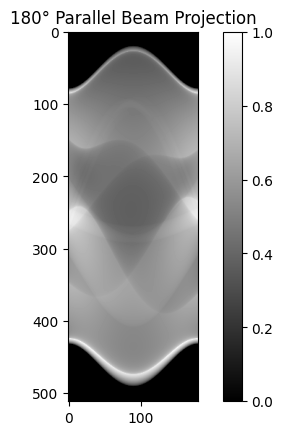

In [3]:
###2.1  创建Shepp-Logan phantom的投影数据
# 用矩阵表示物体的密度分布，每个像素点的值代表该点的密度。
def forward_projection(theta_proj, N, N_d):
    shep = np.array( #定义 Shepp-Logan Phantom 参数
        [
            [1, 0.69, 0.92, 0, 0, 0],
            [-0.8, 0.6624, 0.8740, 0, -0.0184, 0],
            [-0.2, 0.1100, 0.3100, 0.22, 0, -18],
            [-0.2, 0.1600, 0.4100, -0.22, 0, 18],
            [0.1, 0.2100, 0.2500, 0, 0.35, 0],
            [0.1, 0.0460, 0.0460, 0, 0.1, 0],
            [0.1, 0.0460, 0.0460, 0, 0.1, 0],
            [0.1, 0.0460, 0.0230, -0.08, -0.605, 0],
            [0.1, 0.0230, 0.0230, 0, -0.606, 0],
            [0.1, 0.0230, 0.0460, 0.06, -0.605, 0],
        ]
    )
    # 初始化变量
    theta_num = len(theta_proj)
    P = np.zeros((int(N_d), theta_num))
    rho = shep[:, 0]
    ae = 0.5 * N * shep[:, 1]
    be = 0.5 * N * shep[:, 2]
    xe = 0.5 * N * shep[:, 3]
    ye = 0.5 * N * shep[:, 4]
    alpha = shep[:, 5]
    alpha = alpha * np.pi / 180 # 转换为弧度
    theta_proj = theta_proj * np.pi / 180  # 转换为弧度
    TT = np.arange(-(N_d - 1) / 2, (N_d - 1) / 2 + 1)
    # 计算前向投影
    for k1 in range(theta_num): # 遍历每个投影角度k1
        P_theta = np.zeros(int(N_d))
        for k2 in range(len(xe)): # 遍历每个椭圆k2，计算每个椭圆对当前角度投影的贡献
            # 计算椭圆在当前角度的有效面积
            a = (ae[k2] * np.cos(theta_proj[k1] - alpha[k2])) ** 2 + (
                be[k2] * np.sin(theta_proj[k1] - alpha[k2])
            ) ** 2
            # 计算当前投影线与椭圆的交点
            temp = ( 
                a
                - (
                    TT
                    - xe[k2] * np.cos(theta_proj[k1])
                    - ye[k2] * np.sin(theta_proj[k1])
                )
                ** 2
            )
            #用于索引有效交点，计算投影值 P_theta
            ind = temp > 0
            P_theta[ind] += rho[k2] * (2 * ae[k2] * be[k2] * np.sqrt(temp[ind])) / a
        P[:, k1] = P_theta
    # 归一化投影数据,确保投影值在 0 到 1 的范围内
    P_min = np.min(P)
    P_max = np.max(P)
    P = (P - P_min) / (P_max - P_min)
    return P

#N_d = 2 * np.ceil(np.linalg.norm(np.array(I.shape) - np.floor((np.array(I.shape) - 1) / 2) - 1)) - 4
N_d = N #设置投影数据的尺寸与图像尺寸相同
theta = np.arange(0, 180, 1)

P = forward_projection(theta, N, int(N_d))
plt.imshow(P, cmap='gray')
plt.colorbar()
plt.title('180° Parallel Beam Projection')

C:\Users\18148\AppData\Local\Temp\ipykernel_11848\2802715859.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  filterRL[i] = -1.0 / np.power((i - N / 2) * np.pi * d, 2.0)


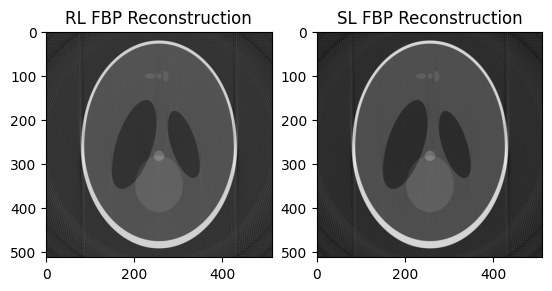

In [4]:
### 3.1 基于滤波反投影的方法

# 1）两种滤波器的实现
# Ram - Lak 滤波器
def RLFilter(N, d):
    filterRL = np.zeros((N,))
    # 计算每个频率分量的值，负的二次函数形式用于设置滤波器的形状
    for i in range(N):
        filterRL[i] = -1.0 / np.power((i - N / 2) * np.pi * d, 2.0)
        if np.mod(i - N / 2, 2) == 0:
            filterRL[i] = 0
    filterRL[int(N / 2)] = 1 / (4 * np.power(d, 2.0)) #中心频率的值被设置为1/(4 * d^2)
    return filterRL

# Shepp - Logan 滤波器
def SLFilter(N, d):
    # 采用公式计算每个频率分量，强调在某些频率下的响应
    filterSL = np.zeros((N,))
    for i in range(N):
        # filterSL[i] = - 2 / (np.power(np.pi, 2.0) * np.power(d, 2.0) * (np.power((4 * (i - N / 2)), 2.0) - 1))
        filterSL[i] = -2 / (np.pi**2.0 * d**2.0 * (4 * (i - N / 2) ** 2.0 - 1))
    return filterSL

# 2）定义用于存储重建后的图像的数组
channels = 512
def RL_Transform(image, steps):
    #channels = len(image[0])
    # print(channels)
    origin = np.zeros((steps, channels, channels))
    # filter = RLFilter(channels, 1)
    filter = RLFilter(channels, 1)
    for i in range(steps):
        projectionValue = image[:, i]
        projectionValueFiltered = convolve(filter, projectionValue, "same")
        projectionValueExpandDim = np.expand_dims(projectionValueFiltered, axis=0)
        projectionValueRepeat = projectionValueExpandDim.repeat(channels, axis=0)
        origin[i] = ndimage.rotate(
            projectionValueRepeat, i * 180 / steps, reshape=False
        ).astype(np.float64)
    iradon = np.sum(origin, axis=0)
    return iradon


def SL_Transform(image, steps):
    # channels = len(image[0])
    origin = np.zeros((steps, channels, channels))
    # filter = RLFilter(channels, 1)
    filter = SLFilter(channels, 1)
    for i in range(steps):
        projectionValue = image[:, i]
        projectionValueFiltered = convolve(filter, projectionValue, "same")
        projectionValueExpandDim = np.expand_dims(projectionValueFiltered, axis=0)
        projectionValueRepeat = projectionValueExpandDim.repeat(channels, axis=0)
        origin[i] = ndimage.rotate(
            projectionValueRepeat, i * 180 / steps, reshape=False
        ).astype(np.float64)
    iradon = np.sum(origin, axis=0)
    return iradon


RL = RL_Transform(P, len(P[0]))
SL = SL_Transform(P, len(P[0]))
# 对图像进行上下翻转
RL = np.flipud(RL)
SL = np.flipud(SL)
# 可视化重建结果
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(RL, cmap="gray")
plt.title("RL FBP Reconstruction")
plt.subplot(1, 2, 2)
plt.imshow(SL, cmap="gray")
plt.title("SL FBP Reconstruction")
plt.show()


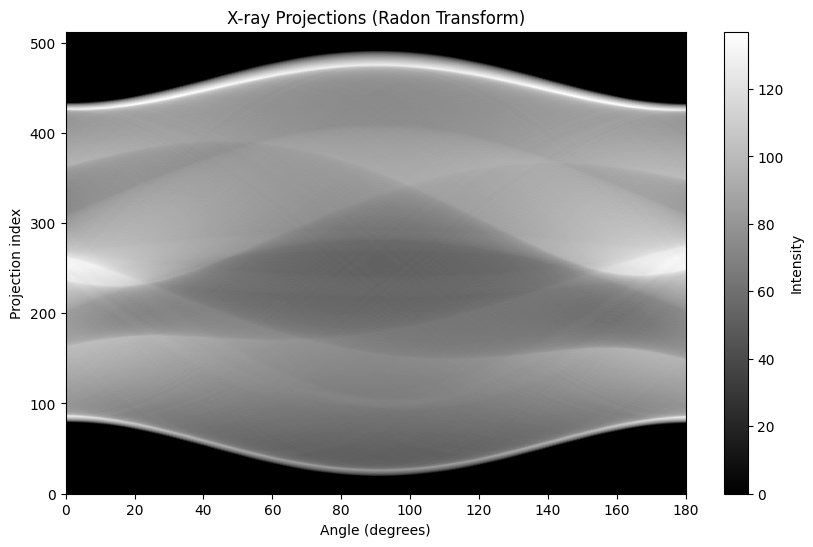

In [5]:
#### 2. 模拟 X 射线投影数据

# 选择投影角度
theta = np.arange(0, 180, 1)  # 从 0° 到 179°，每隔 1° 取一个角度

# 计算 Radon 变换（X 射线投影数据）
sinogram = radon(phantom, theta=theta)

# 可视化投影数据
plt.figure(figsize=(10, 6))
plt.imshow(sinogram, cmap='gray', aspect='auto', extent=(0, 180, 0, sinogram.shape[0]))
plt.title("X-ray Projections (Radon Transform)")
plt.xlabel("Angle (degrees)")
plt.ylabel("Projection index")
plt.colorbar(label='Intensity')
plt.show()

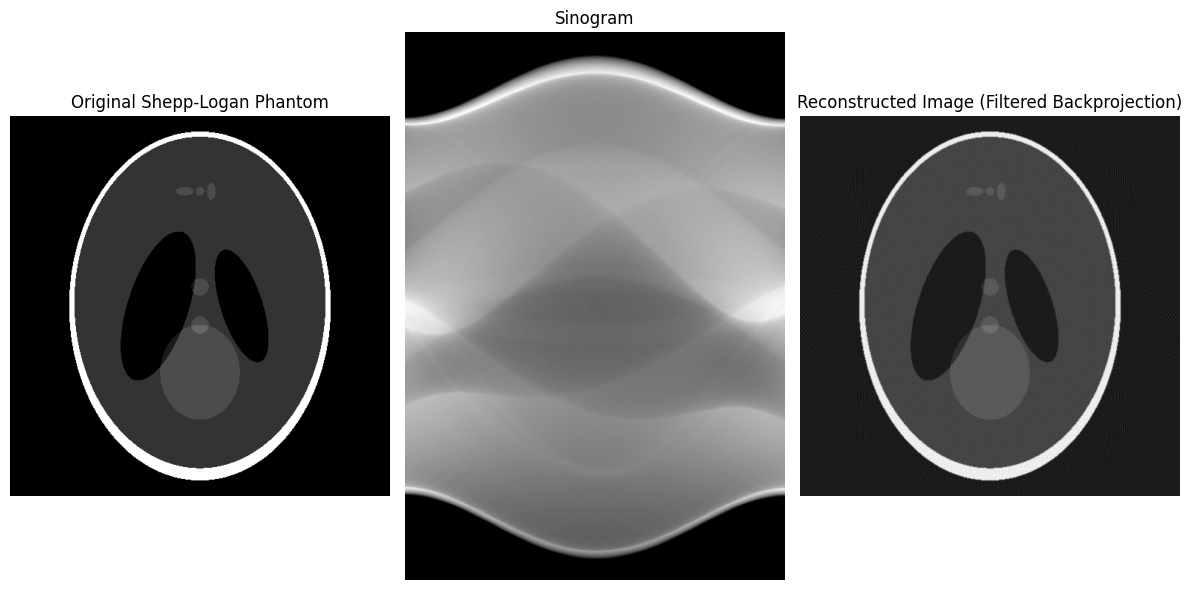

In [6]:
### 3.1 基于滤波反投影的方法
#### Ram-Lak 滤波器进行滤波处理
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon

def apply_filter_and_backprojection(sinogram, theta):
    """应用 Ram-Lak 滤波器并进行反投影"""
    # iradon函数在执行反投影时，会默认应用Ram-Lak滤波器
    reconstructed_image = iradon(sinogram, theta=theta, interpolation='linear')
    return reconstructed_image

# 获取投影数据
theta = np.arange(0, 180, 1)
sinogram = radon(phantom, theta=theta)

# 使用滤波反投影方法重建图像
reconstructed_image_fb = apply_filter_and_backprojection(sinogram, theta)

# 可视化结果
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Shepp-Logan Phantom")
plt.imshow(phantom, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Sinogram")
plt.imshow(sinogram, cmap='gray', aspect='auto', extent=(0, 180, 0, sinogram.shape[0]))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Reconstructed Image (Filtered Backprojection)")
plt.imshow(reconstructed_image_fb, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 3.2 ART重建算法
import numpy as np
import matplotlib.pyplot as plt
from phantominator import shepp_logan
from skimage.transform import radon, iradon

# 系统设置
N = 512
ANG = 180 # 投影的角度范围
VIEW = 360 # 每个角度的视图数量
# 生成从0到180度的均匀分布的投影角度（360个），用于 Radon 变换
THETA = np.linspace(0, ANG, VIEW + 1)[:-1] 

# 定义线性变换 A 和其转置 AT
A = lambda x: radon(x, THETA, circle=False).astype(np.float32)
AT = lambda y: iradon(y, THETA, circle=False, output_size=N).astype(np.float32) / (np.pi / (2 * len(THETA)))

# 生成投影数据
p = A(phantom)

# 添加噪声（可选，用于模拟低剂量情况）
# 可以根据需求添加噪声，这里我们保持简单
# noise_level = 0.1
# p += noise_level * np.random.normal(size=p.shape)

# 计算均方误差 (MSE)
def mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

# 计算峰值信噪比 (PSNR)
def psnr(image1, image2):
    mse_value = mse(image1, image2)
    if mse_value == 0:
        return 100  # 如果没有误差，返回一个高值（理论上的 PSNR）
    max_pixel = 1.0  # 假设图像像素值范围是 [0, 1]
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))

# ART 重建函数
def ART(A, AT, b, x, mu=1e0, niter=100, bpos=True):
    """
    A：线性变换函数。
    AT：转置变换函数。
    b：投影数据。
    x：当前重建图像。
    mu：步长参数，用于控制更新幅度。
    niter：迭代次数。
    bpos：布尔值，是否强制重建图像中的值为非负
    """
    ATA = AT(A(np.ones_like(x)))    # 计算矩阵ATA
    mse_values = []  # 初始化 MSE 值列表
    psnr_values = []  # 初始化 PSNR 值列表
    for i in range(int(niter)):
        # np.divide计算更新量
        x = x + np.divide(mu * AT(b - A(x)), ATA)

        if bpos:
            x[x < 0] = 0 #正值约束

        # # 实时显示重建进程
        # plt.imshow(x, cmap='gray')
        # plt.title("%d / %d" % (i + 1, niter))
        # plt.axis('off')
        # plt.pause(0.1)  # 暂停以显示图像
        # plt.close()
        # 计算 MSE 和 PSNR
        current_mse = mse(phantom, x)
        current_psnr = psnr(phantom, x)
        mse_values.append(current_mse)
        psnr_values.append(current_psnr)

    return x, mse_values, psnr_values

# 初始化重建图像
x0 = np.zeros_like(phantom)

# 使用 ART 进行重建
#x_art = ART(A, AT, p, x0, mu=1e0, niter=200)
x_art, mse_curve, psnr_curve = ART(A, AT, p, x0, mu=1e0, niter=200)
# 显示重建图像
plt.figure(figsize=(8, 4))
plt.imshow(x_art, cmap='gray')
plt.title("ART Reconstruction")
plt.axis('off')
plt.show()

# 创建双 Y 轴绘图
fig, ax1 = plt.subplots(figsize=(8, 5))

# 绘制 MSE 曲线
ax1.plot(mse_curve, label='MSE', color='blue', marker='o')
ax1.set_ylabel('MSE Value', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Iterations')
ax1.grid()

# 创建第二个 Y 轴
ax2 = ax1.twinx()  # 创建一个共享 X 轴的第二个 Y 轴
ax2.plot(psnr_curve, label='PSNR', color='orange', marker='o')
ax2.set_ylabel('PSNR Value', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 添加标题和图例
plt.title("Error Metrics")
fig.tight_layout()  # 自动调整布局以适应标签

# 显示图形
plt.show()

RL - MSE: 0.0244, PSNR: 22.1413 dB
SL - MSE: 0.0243, PSNR: 22.1621 dB
FB - MSE: 0.0011, PSNR: 35.6097 dB
X-Art - MSE: 0.0369, PSNR: 20.3496 dB


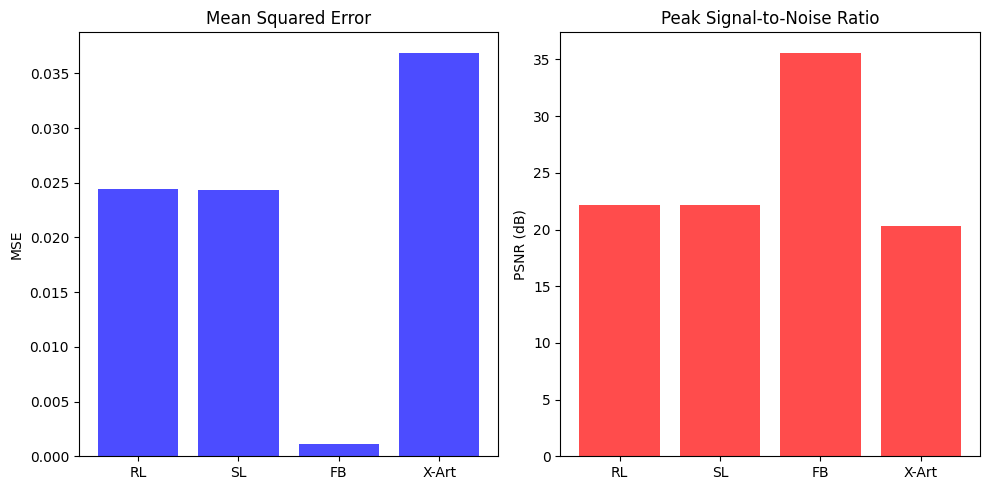

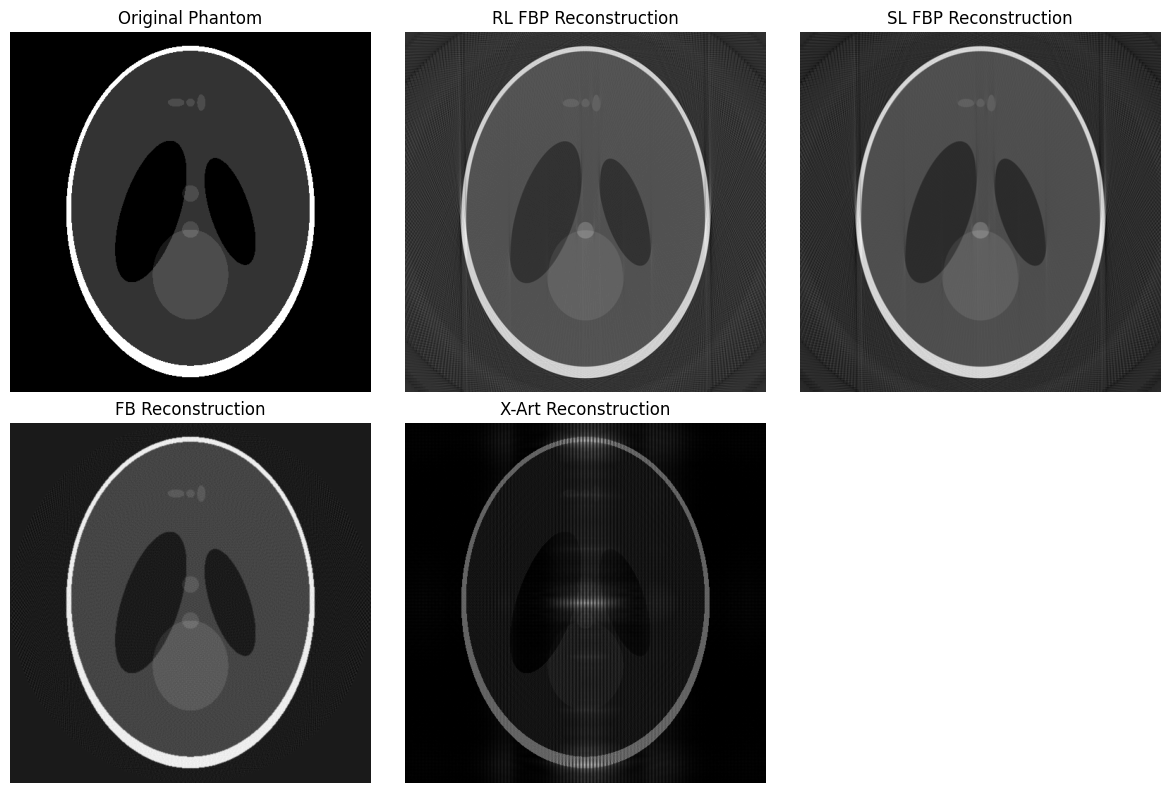

In [16]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

# 已经有以下变量
# RL, SL, reconstructed_image_fb, x_art, phantom

# 计算误差指标
def calculate_metrics(original, reconstructed):
    mse = mean_squared_error(original, reconstructed)
    psnr = peak_signal_noise_ratio(original, reconstructed)
    return mse, psnr

# 计算不同重建图像的误差
mse_rl, psnr_rl = calculate_metrics(phantom, RL)
mse_sl, psnr_sl = calculate_metrics(phantom, SL)
mse_fb, psnr_fb = calculate_metrics(phantom, reconstructed_image_fb)
mse_art, psnr_art = calculate_metrics(phantom, x_art)

# 打印结果
print(f"RL - MSE: {mse_rl:.4f}, PSNR: {psnr_rl:.4f} dB")
print(f"SL - MSE: {mse_sl:.4f}, PSNR: {psnr_sl:.4f} dB")
print(f"FB - MSE: {mse_fb:.4f}, PSNR: {psnr_fb:.4f} dB")
print(f"X-Art - MSE: {mse_art:.4f}, PSNR: {psnr_art:.4f} dB")

# 绘制误差曲线
methods = ['RL', 'SL', 'FB', 'X-Art']
mse_values = [mse_rl, mse_sl, mse_fb, mse_art]
psnr_values = [psnr_rl, psnr_sl, psnr_fb, psnr_art]

plt.figure(figsize=(10, 5))

# MSE 曲线
plt.subplot(1, 2, 1)
plt.bar(methods, mse_values, color='b', alpha=0.7)
plt.ylabel('MSE')
plt.title('Mean Squared Error')

# PSNR 曲线
plt.subplot(1, 2, 2)
plt.bar(methods, psnr_values, color='r', alpha=0.7)
plt.ylabel('PSNR (dB)')
plt.title('Peak Signal-to-Noise Ratio')

plt.tight_layout()
plt.show()

# 可视化原始图像和重建图像
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.imshow(phantom, cmap="gray")
plt.title("Original Phantom")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(RL, cmap="gray")
plt.title("RL FBP Reconstruction")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(SL, cmap="gray")
plt.title("SL FBP Reconstruction")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(reconstructed_image_fb, cmap="gray")
plt.title("FB Reconstruction")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(x_art, cmap="gray")
plt.title("X-Art Reconstruction")
plt.axis('off')

plt.tight_layout()
plt.show()

Image 1 - MSE: 0.02443046359424536, PSNR: 16.12068291744848
Image 2 - MSE: 0.024313821370830442, PSNR: 16.14146778308472
Image 3 - MSE: 0.0010992291057322805, PSNR: 29.589117807470696
Image 4 - MSE: 0.03690639551722878, PSNR: 14.328983683350476


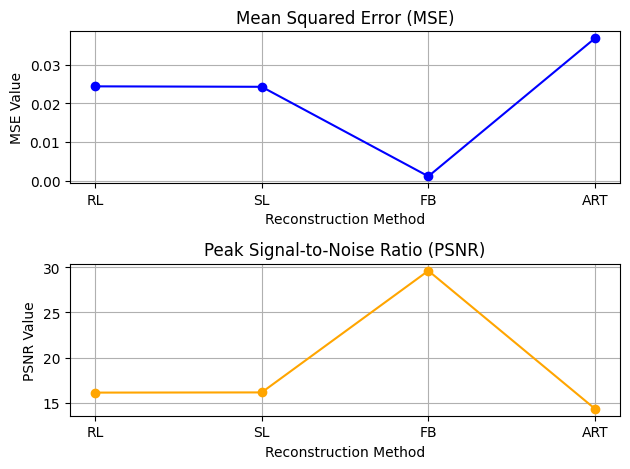

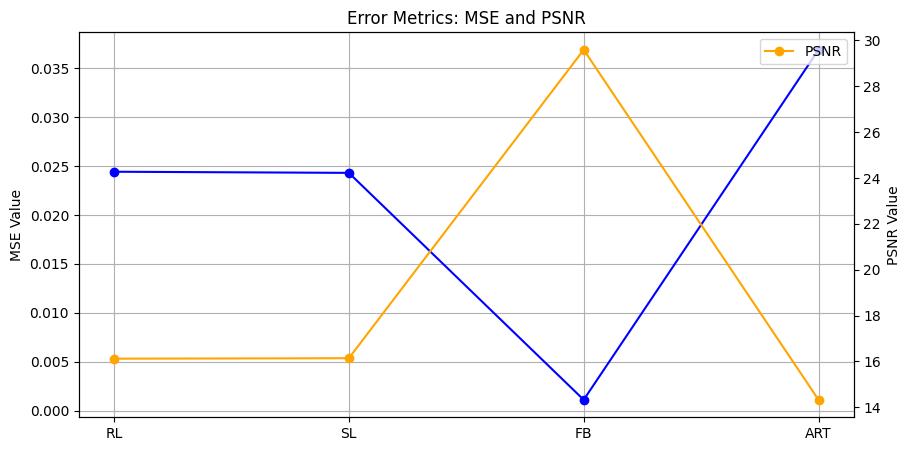

In [ ]:
# 计算每张重建图像的误差指标
reconstructed_images = [RL, SL, reconstructed_image_fb, x_art]
mse_values = [mse(phantom, img) for img in reconstructed_images]
psnr_values = [psnr(phantom, img) for img in reconstructed_images]

# 输出误差指标
for i, img in enumerate(reconstructed_images):
    print(f"Image {i+1} - MSE: {mse_values[i]}, PSNR: {psnr_values[i]}")

# 绘制 MSE 曲线
plt.subplot(2, 1, 1)
plt.plot(['RL', 'SL', 'FB', 'ART'], mse_values, marker='o', color='blue')
plt.title("Mean Squared Error (MSE)")
plt.xlabel("Reconstruction Method")
plt.ylabel("MSE Value")
plt.grid()

# 绘制 PSNR 曲线
plt.subplot(2, 1, 2)
plt.plot(['RL', 'SL', 'FB', 'ART'], psnr_values, marker='o', color='orange')
plt.title("Peak Signal-to-Noise Ratio (PSNR)")
plt.xlabel("Reconstruction Method")
plt.ylabel("PSNR Value")
plt.grid()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))

# 创建第一个 Y 轴
plt.plot(['RL', 'SL', 'FB', 'ART'], mse_values, marker='o', color='blue', label='MSE')
plt.ylabel("MSE Value")
plt.grid()

# 创建第二个 Y 轴
ax2 = plt.gca().twinx()  # 创建一个共享 X 轴的第二个 Y 轴
ax2.plot(['RL', 'SL', 'FB', 'ART'], psnr_values, marker='o', color='orange', label='PSNR')
ax2.set_ylabel("PSNR Value")

# 添加标题和标签
plt.title("Error Metrics: MSE and PSNR")
plt.xlabel("Reconstruction Method")

# 添加图例
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()